In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
%load_ext autoreload
%autoreload 2

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.000690304967538


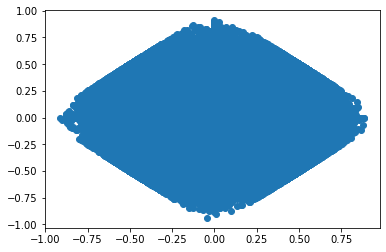

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.0, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = True)
S = 2 * S - 1
S = ProjectRowstoL1NormBall(S.T).T

print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

plt.scatter(S[0,:], S[2,:])

INPUT_STD = 0.5
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 1000
model = MinibatchLDMIBSS(s_dim = s_dim, x_dim = x_dim,
                     set_ground_truth = True, S = S, A = A)

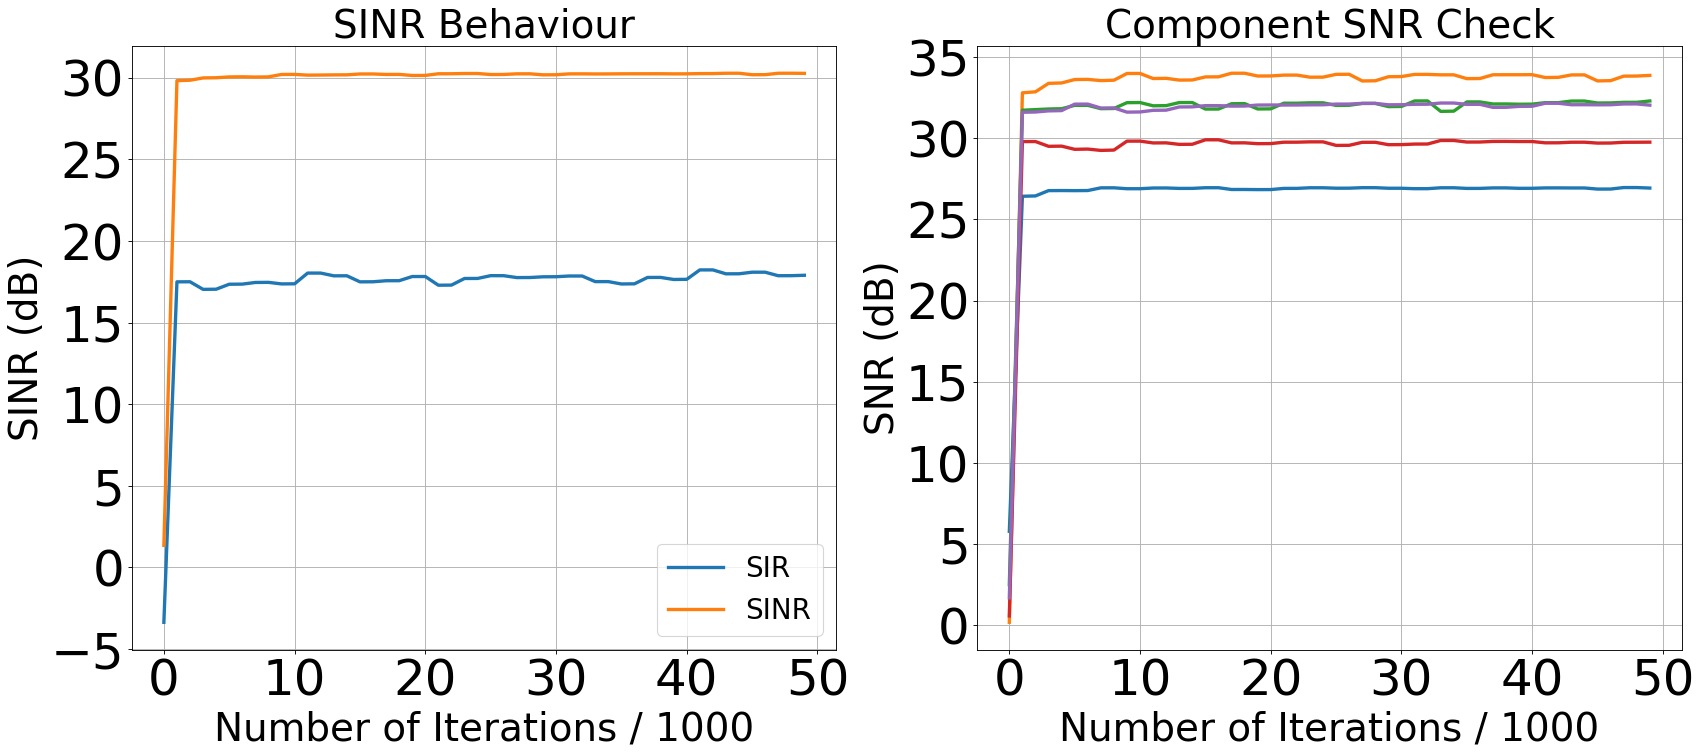

100%|██████████| 600/600 [00:13<00:00, 43.92it/s]


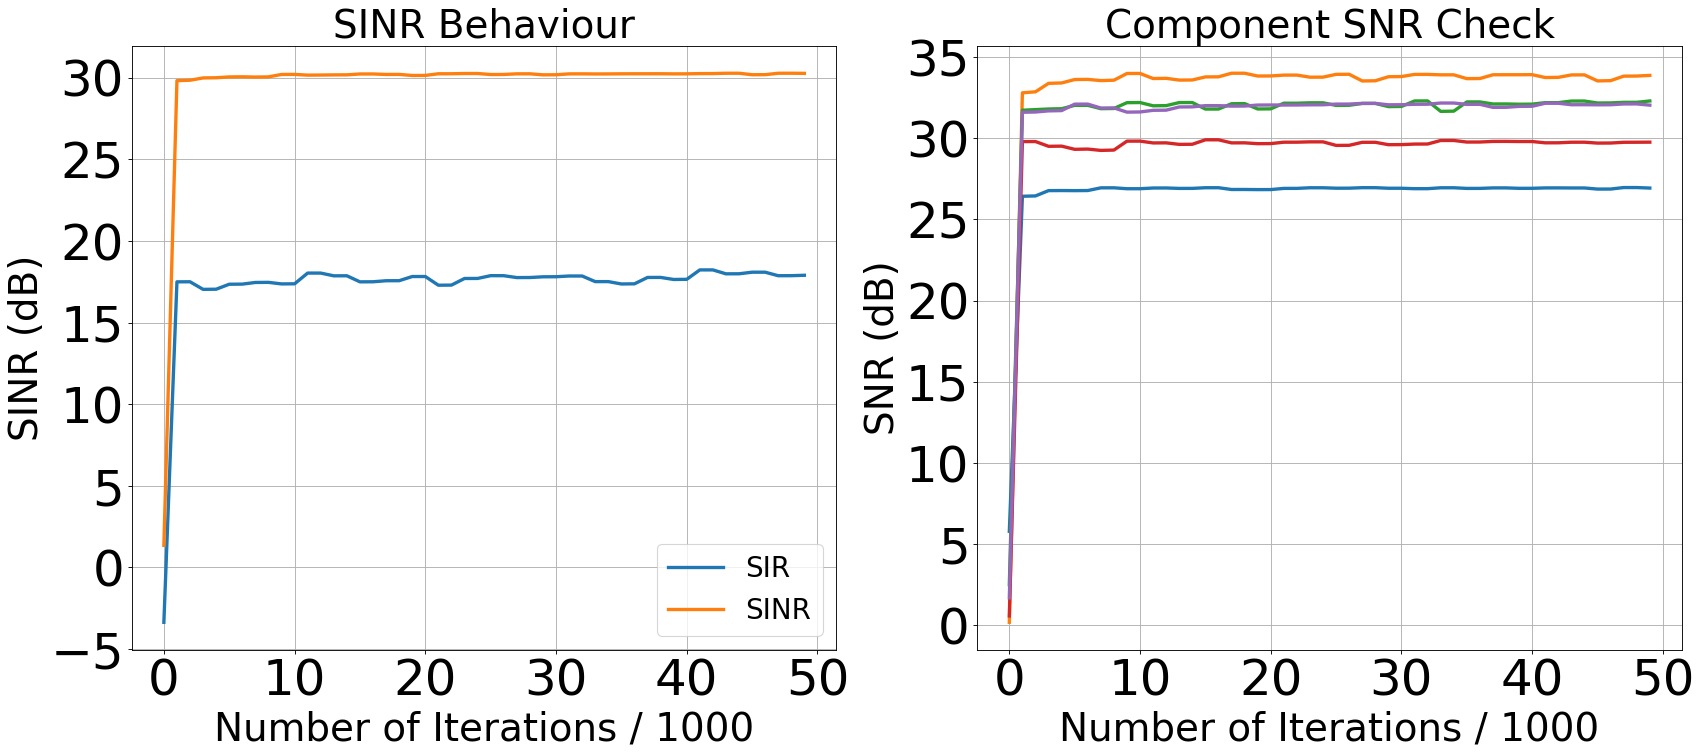

In [5]:
t0 = time()
model.fit_batch_sparse(X, batch_size = 20000, epsilon = 1e-5, mu_start = 200, 
                       n_iterations_per_batch = 600, method = "covariance", 
                       debug_iteration_point = debug_iteration_point,
                       plot_in_jupyter = True)
t1 = time()

In [6]:
(t1 - t0)/60

5.295829427242279

In [7]:
W = model.W
Y = W @ X
10 * np.log10(CalculateSINR(Y, S)[0])

30.264693488041186

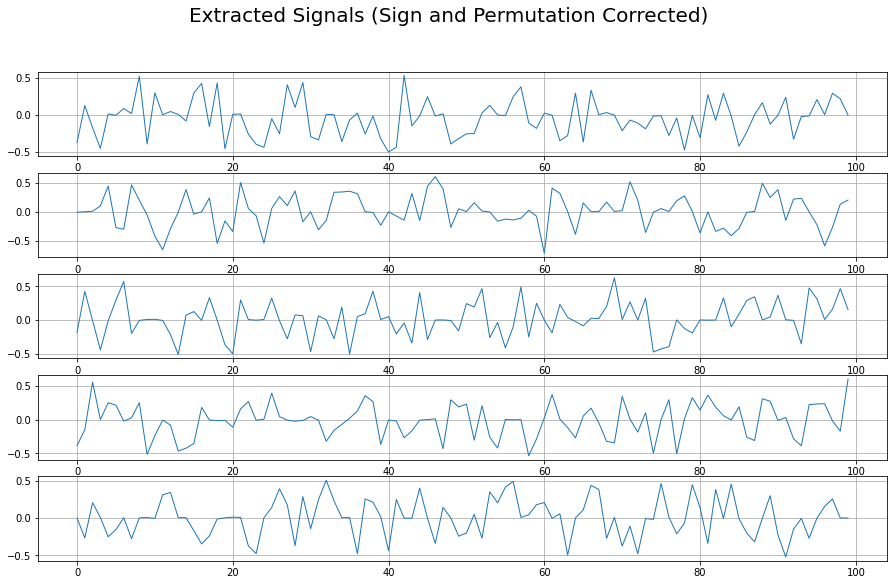

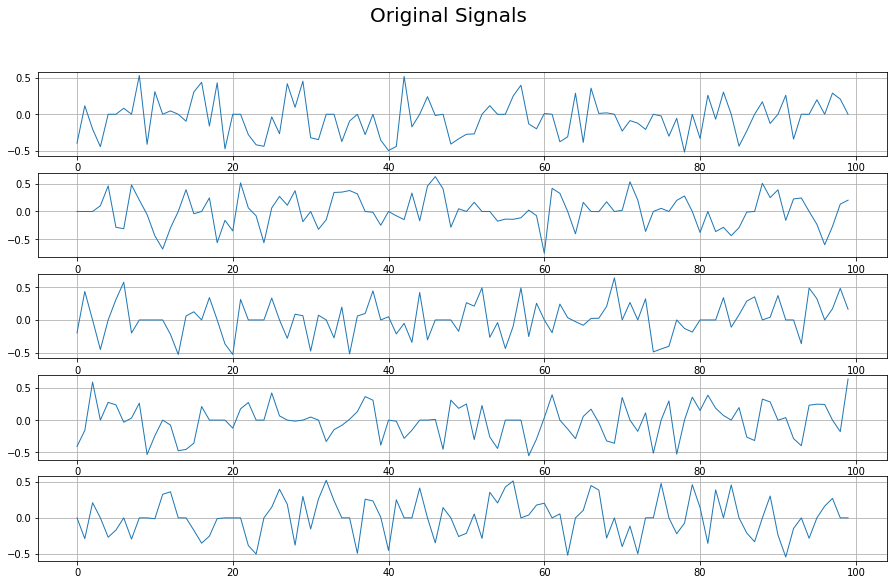

In [8]:
Y = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)